# MMPose预训练模型预测-Python API

同济子豪兄 2023-4-1

## 进入 mmpose 主目录

In [1]:
import os
os.chdir('mmpose')

## 导入工具包

In [2]:
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

/home/cine/miniconda3/envs/openmmlab-pose/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入待测图像

In [4]:
img_path = 'data/test/multi-person.jpeg'

In [5]:
# Image.open(img_path)

## 构建目标检测模型（任选一个运行）

In [6]:
# Faster R CNN
detector = init_detector(
    'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py',
    'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth',
    device=device
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


In [7]:
# RTMPose-Tiny
# https://github.com/open-mmlab/mmpose/tree/dev-1.x/projects/rtmpose
detector = init_detector(
    'projects/rtmpose/rtmdet/person/rtmdet_m_640-8xb32_coco-person.py',
    'https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth',
    device=device
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth


Downloading: "https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth" to /home/cine/.cache/torch/hub/checkpoints/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth


## 构建人体姿态估计模型

In [8]:
pose_estimator = init_pose_estimator(
    'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py',
    'https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth


## 预测-目标检测

In [9]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

06/04 11:40:45 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".


In [10]:
# 获取目标检测预测结果
detect_result = inference_detector(detector, img_path)

/home/cine/miniconda3/envs/openmmlab-pose/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
detect_result.keys()

['gt_instances', 'ignored_instances', 'pred_instances']

In [12]:
# 预测类别
detect_result.pred_instances.labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')

In [13]:
# 置信度
detect_result.pred_instances.scores

tensor([0.8479, 0.8386, 0.8108, 0.8094, 0.7652, 0.7554, 0.7069, 0.6804, 0.6572,
        0.6090, 0.5753, 0.5710, 0.5349, 0.5048, 0.4649, 0.4232, 0.4221, 0.3682,
        0.3585, 0.3360, 0.3079, 0.2857, 0.2100, 0.2037, 0.2015, 0.2009, 0.1956,
        0.1917, 0.1903, 0.1890, 0.1812, 0.1784, 0.1619, 0.1601, 0.1543, 0.1540,
        0.1485, 0.1457, 0.1455, 0.1441, 0.1386, 0.1364, 0.1327, 0.1275, 0.1260,
        0.1251, 0.1250, 0.1243, 0.1216, 0.1173, 0.1170, 0.1138, 0.1113, 0.1111,
        0.1103, 0.1080, 0.1051, 0.1031, 0.1028, 0.1023, 0.1019, 0.1012, 0.1008,
        0.0993, 0.0989, 0.0967, 0.0960, 0.0956, 0.0944, 0.0943, 0.0935, 0.0909,
        0.0897, 0.0897, 0.0892, 0.0886, 0.0881, 0.0868, 0.0867, 0.0866, 0.0864,
        0.0863, 0.0861, 0.0858, 0.0849, 0.0846, 0.0841, 0.0834, 0.0810, 0.0806,
        0.0804, 0.0789, 0.0786, 0.0764, 0.0748, 0.0747, 0.0741, 0.0737, 0.0730,
        0.0724], device='cuda:0')

In [14]:
# 框坐标：左上角X坐标、左上角Y坐标、右下角X坐标、右下角Y坐标
# detect_result.pred_instances.bboxes

## 置信度阈值过滤，获得最终目标检测预测结果

In [15]:
# 置信度阈值
CONF_THRES = 0.5

In [16]:
pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4]

In [17]:
bboxes

array([[1734.5668 ,  100.28979, 2113.1    , 1293.3635 ],
       [1263.3546 ,  100.72577, 1716.5182 , 1330.0189 ],
       [   0.     ,  245.72191,  175.4084 , 1137.8104 ],
       [ 722.6692 ,  169.44176, 1167.1973 , 1285.2493 ],
       [1078.0898 ,  214.93707, 1356.7361 , 1284.2297 ],
       [ 123.68781,  211.18466,  342.7428 , 1093.4517 ],
       [ 438.89334,  425.76077,  586.3573 ,  920.2032 ],
       [ 546.91595,  410.832  ,  660.5097 ,  920.0567 ],
       [2088.826  ,  483.11224, 2231.1497 ,  928.4489 ],
       [1984.2957 ,  490.75037, 2107.5317 ,  939.24384],
       [ 708.9979 ,  304.96957,  846.7057 , 1005.5404 ],
       [2365.2175 ,  502.58627, 2452.044  ,  921.40234],
       [1660.906  ,  468.2752 , 1786.0048 ,  949.4937 ],
       [2285.727  ,  558.2153 , 2377.0618 ,  711.69073]], dtype=float32)

## 预测-关键点

In [18]:
# 获取每个 bbox 的关键点预测结果
pose_results = inference_topdown(pose_estimator, img_path, bboxes)

06/04 11:41:04 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


In [19]:
len(pose_results)

14

In [20]:
# 把多个bbox的pose结果打包到一起
data_samples = merge_data_samples(pose_results)

In [21]:
data_samples.keys()

['_pred_heatmaps', 'pred_fields', 'gt_instances', 'pred_instances']

## 预测结果-关键点坐标

In [22]:
# 每个人 17个关键点 坐标
data_samples.pred_instances.keypoints.shape

(14, 17, 2)

In [23]:
# 索引为 0 的人，每个关键点的坐标
data_samples.pred_instances.keypoints[0,:,:]

array([[1906.3568306 ,  190.00334692],
       [1929.65905126,  178.35223627],
       [1894.70572027,  166.70112562],
       [1964.61238225,  190.00334692],
       [1859.75238927,  190.00334692],
       [2011.21682358,  318.16556406],
       [1813.14794795,  329.81667471],
       [2092.7745959 ,  492.9322238 ],
       [1778.19461695,  434.67667055],
       [1976.26349258,  411.37444925],
       [1766.54350662,  504.58333445],
       [1964.61238225,  667.69888353],
       [1824.79905828,  656.04777288],
       [1941.31016159,  935.67442846],
       [1824.79905828,  912.37220716],
       [1929.65905126, 1122.09219885],
       [1859.75238927, 1191.99886274]])

## 预测结果-关键点热力图

In [24]:
# 每一类关键点的预测热力图
data_samples.pred_fields.heatmaps.shape

(17, 1418, 2520)

In [25]:
idx_point = 13
heatmap = data_samples.pred_fields.heatmaps[idx_point,:,:]

In [26]:
heatmap.shape

(1418, 2520)

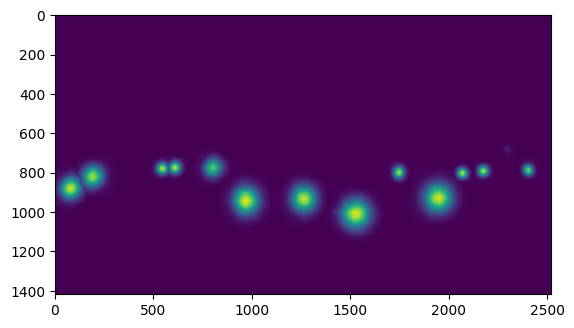

In [27]:
# 索引为 idx 的关键点，在全图上的预测热力图
plt.imshow(heatmap)
plt.show()

## MMPose官方可视化工具`visualizer`

In [28]:
# 半径
pose_estimator.cfg.visualizer.radius = 10
# 线宽
pose_estimator.cfg.visualizer.line_width = 8
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# 元数据
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

06/04 11:41:16 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


In [29]:
# 元数据
# pose_estimator.dataset_meta

## 展示可视化效果

In [30]:
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

img_output = visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=True,
            draw_bbox=True,
            show_kpt_idx=True,
            show=False,
            wait_time=0,
            out_file='outputs/B2.jpg'
)

In [31]:
img_output.shape

(2836, 2520, 3)

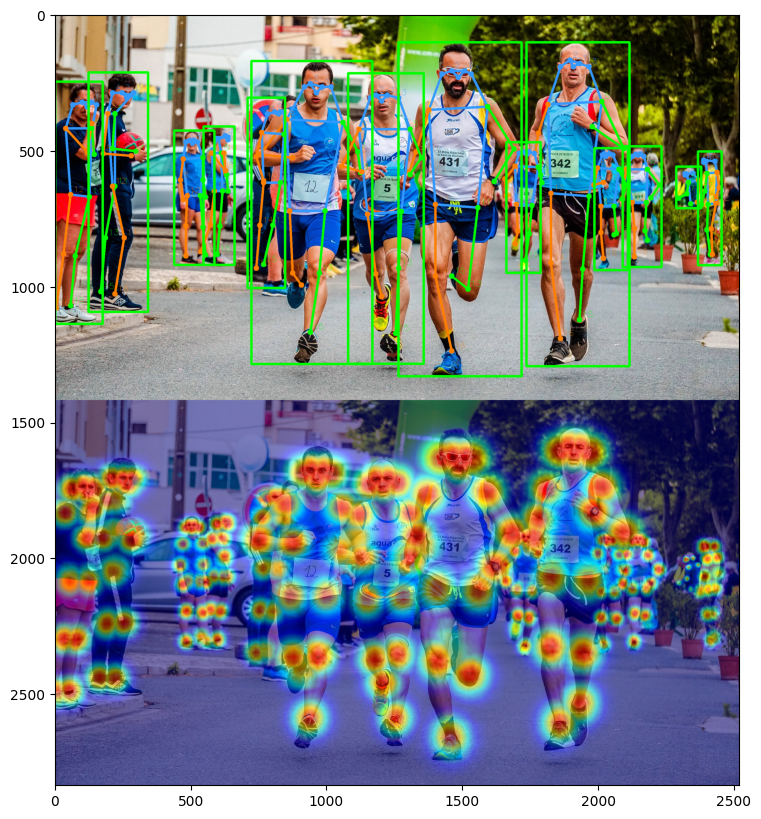

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(img_output)
plt.show()